<a href="https://colab.research.google.com/github/GiulianoCalabrese/openturns/blob/master/INNEO_SPACE_LAB_2_2_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![inneo_logo](https://drive.google.com/uc?id=1sLsgpURBFrczz5HMbr9Ci9qzHV_Awgvq) <br/>INNEO Summer school - AI and EO 

# Classify Earth observation images with deep learning models
Deep learning models are the state of the art in image classification. In this practical we will learn how to build a simple deep learning image classification model with pytorch and use it to classify satellite images. We will then use the state of the art model architectures available in the torchvision package to perform the same task.

# Part 2 -  Using a CNN to classify TIFF images
Convolutional Neural Network (CNN) architectures are the current state of the art in image classification. We will use pytorch to build a CNN to classify images from the EuroSAT dataset. For this second part we will classify TIFF images. Find out more about the EuroSAT dataset [here](https://github.com/phelber/EuroSAT) and [here](https://arxiv.org/pdf/1709.00029.pdf).

In [1]:
# Import needed libraries

import os
import time

# Pytorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from tqdm import tqdm as tqdm

import torchvision
from torchvision import transforms

from torchsummary import summary

import random

from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from osgeo import gdal

We check if we have GPU, if not we will run our models on CPU and set the device accordingly.

In [2]:
# Check if GPU is available and set device accordingly
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# download images for the lab
# might take some time - few minutes
import requests
url = 'https://filesender.renater.fr/download.php?token=c4da6853-78ec-4420-a986-ad718fe04f1c&files_ids=16610020'
r = requests.get(url, allow_redirects=True)

with open('lab2.zip', 'wb') as f:
    f.write(r.content)

# unzip files
!unzip -uq "lab2.zip" -d "lab2"

In [4]:
# Path to dataset
TIFF_DATA_BASE_PATH = 'lab2/TIFF'

Our data is in a folder organized by class labels. We can list the content of this folder to get the number of classes and their names.

In [5]:
# List of the names of image classes
classes = os.listdir(TIFF_DATA_BASE_PATH)
print('Number of classes: {}'.format(len(classes)))

Number of classes: 10


In [6]:
# Disctionary of class names with their index as key
classes_dict = dict(enumerate(classes))
#print('Class names: {}'.format([k for k in classes_dict.values()]))

In [7]:
print('Class ID and name:')
classes_dict

Class ID and name:


{0: 'Industrial',
 1: 'AnnualCrop',
 2: 'Highway',
 3: 'River',
 4: 'HerbaceousVegetation',
 5: 'Forest',
 6: 'SeaLake',
 7: 'Residential',
 8: 'Pasture',
 9: 'PermanentCrop'}

## 1 - Define the dataset
To train our CNN, we will use part of the data, and we will leave another part out to use for testing the CNN. We will also use a part of the training data to validate the training. Therefore, we will pick samples randomly and split the data into 80% for training (with 10% for validation) and 20% for testing.

We specify whether image normalization should be performed or not when we create our dataset.

In [8]:
# Normalize images?
NORM_IMG = True

Our images have 13 channels. In case we do not want to use all of them, we specify the specific channels to use. 

In [9]:
CH_SELECT = True
# list of channels to use, indexed from 0 to 12 
CH_LST = [1,2,3,7] # 1,2,3,7 = B,G,R,NIR

Note: We are using Sentinel-2 data, be mindful of the spatial resolution of the chosen channels. See [this link](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial) for spatial resolutions of Sentinel-2 spectral bands.

We create the train/valid/test splits and get the list of classes for each image.

In [10]:
# get the images and their class and make the train/valid/test split

# Number of classes to use
NB_CLS = 3

# use a fraction or all( 1 = 100% ) the images for the chosen classes 
IMG_PROP = 0.7

# List of the path to the folder for each class
tiff_classes_path = [os.path.join(TIFF_DATA_BASE_PATH, image_cls) for image_cls in classes[:NB_CLS]]
   
# List of the path to each image
tiff_data_list = [os.path.join(images_path, image_id) for images_path in tiff_classes_path 
                    for image_id in os.listdir(images_path)]
np.random.seed(0)
tiff_all_data = np.random.choice([k for k,v in enumerate(tiff_data_list)], round(len(tiff_data_list) * IMG_PROP), replace=False)

tiff_all_data_list = [tiff_data_list[k] for k in tiff_all_data]

# Create the list of test samples with 20% of the images chosen randomly
np.random.seed(0)
tiff_test_samples = np.random.choice([k for k,v in enumerate(tiff_all_data_list)], 
                                round(len(tiff_all_data_list) * 0.2), replace=False)

# Create the list of validation samples with 10% of the remaining images
np.random.seed(0)
tiff_valid_samples = np.random.choice([k for k,v in enumerate(tiff_all_data_list) if k not in tiff_test_samples], 
                                round(len(tiff_all_data_list) * 0.1), replace=False)

# Create the list of training samples 
tiff_train_samples = [k for k,v in enumerate(tiff_all_data_list) if k not in tiff_test_samples]

# List of the class for each image
tiff_all_classes_list = [os.path.basename(os.path.split(tiff_data_path)[0]) for tiff_data_path in tiff_all_data_list]

# list of class for each image for each set
tiff_train_class_list = [tiff_all_classes_list[k] for k in tiff_train_samples]
tiff_valid_class_list = [tiff_all_classes_list[k] for k in tiff_valid_samples]
tiff_test_class_list = [tiff_all_classes_list[k] for k in tiff_test_samples]

# list of path to each image for each set
tiff_train_data_list = [tiff_all_data_list[k] for k in tiff_train_samples]
tiff_valid_data_list = [tiff_all_data_list[k] for k in tiff_valid_samples]
tiff_test_data_list = [tiff_all_data_list[k] for k in tiff_test_samples]

After creating the data set splits, we can look at the proportion of each class in in each split. 
We want to see whether our datasets are balanced or imbalanced in favor of one or another class.

We define a function that counts the number of samples in each class and another one to draw the plot of the values for each data split.

In [11]:

# Function to count the number of samples in each class

def get_class_count(samples):

    count_dict = {}
    
    for class_id in classes:
        count = 0
        for key in samples:
            value = tiff_all_classes_list[key]
            if value == class_id:
                count += 1
                count_dict[value] = count
                
    return(count_dict)
        

We define a function to plot the number of samples in each class.

In [12]:
def plot_from_dict(dict_obj, plot_title, ax, color):
    return( ax.bar(range(len(dict_obj)), list(dict_obj.values()), align='center', color=color), 
                      ax.set_title(plot_title), ax.set_xlabel('classes'), ax.set_ylabel('count'), ax.set_xticks([*range(len(dict_obj))]), 
           ax.set_xticklabels(dict_obj.keys()))
    

We plot the number of samples in each class for each train/valid/test set

(<BarContainer object of 3 artists>,
 Text(0.5, 1.0, 'Test Set'),
 Text(0.5, 0, 'classes'),
 Text(0, 0.5, 'count'),
 [Text(0, 0, 'Industrial'), Text(0, 0, 'AnnualCrop'), Text(0, 0, 'Highway')])

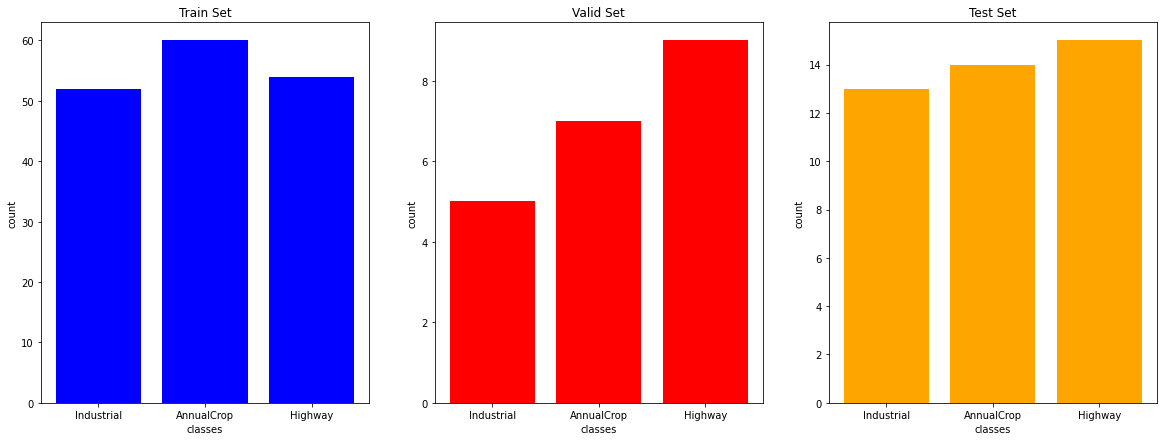

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

my_colors = ['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple']

color_list = np.random.choice(my_colors,3,replace=False)

plot_from_dict(get_class_count(tiff_train_samples), plot_title="Train Set", ax=axes[0], color=color_list[0])
plot_from_dict(get_class_count(tiff_valid_samples), plot_title="Valid Set", ax=axes[1], color=color_list[1])
plot_from_dict(get_class_count(tiff_test_samples), plot_title="Test Set", ax=axes[2], color=color_list[2])

In [14]:
print("Number of samples in each split")
len(tiff_train_data_list), len(tiff_valid_data_list), len(tiff_test_data_list)

Number of samples in each split


(166, 21, 42)

We create the class to read our data from disk and put it in the right format for our model. We use the Gdal library to read the files from disk.

In [15]:
# TIFF image class

class TIFFEODataset(Dataset):
    """EO Dataset of TIFF images. Read images and classes, apply transformations.
    
    Args:
        image_fps (list): list of paths of image files 
        classest (list): list of corresponding image classes names
        transform (callable, optional): Optional transform to be applied on a sample image.
    """
    
    def __init__(self, image_paths, classes_list=None, transform=None):
        
        self.image_fps = image_paths
        self.classes = [classes.index(cls) for cls in classes_list]
        self.transform = transform
       
    def __len__(self):
        return len(self.image_fps)    
    
    def __getitem__(self, idx):
        
        image = gdal.Open(self.image_fps[idx]).ReadAsArray() # array in C x W x H shape
        image = image.transpose(2,1,0) # transpose to H x W x C
        
                  
        if NORM_IMG:
            # we normalize the image
            image = ((image - image.mean()) / image.std()).astype('uint8')
            
        if self.transform:
            image = self.transform(image)
            
        image = image.transpose(2,1,0) # transpose to C x W x H
        class_name = self.classes[idx]
        
        # if channel list specified
        if CH_SELECT:
            # select specific channels
            image = np.stack([image[i,:,:] for i in CH_LST], axis=0)
        
        # else default to RGB
        else :
            image = np.stack([image[i,:,:] for i in [1,2,3]], axis=0)
       
        return image, class_name

We create dataset objects for our train, validation and test sets.

In [16]:
tiff_train_dataset = TIFFEODataset(tiff_train_data_list, tiff_train_class_list)
tiff_valid_dataset = TIFFEODataset(tiff_valid_data_list, tiff_valid_class_list)
tiff_test_dataset = TIFFEODataset(tiff_test_data_list, tiff_test_class_list)

## 2- Load the data

We use Pytorch's data loader to read the data and put it in memory in batches.

In [17]:
BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = False)

## 3- Define the model

We get the number of channels from the first image in our list of images for the train set.

In [18]:
# n channel images
nb_channels = gdal.Open(tiff_train_data_list[0]).ReadAsArray().shape[0]

if not CH_SELECT:
    CH_SELECT = [1,2,3]
    
nb_channels = len(CH_LST)
    
print('Number of input channels: {}'.format(nb_channels))

Number of input channels: 4


We define out CNN class subclassing the torch.nn.Module.

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layer (sees 3x64x64 image tensor)
        self.conv1 = nn.Conv2d(nb_channels, 32, 7, padding=1)
        # convolutional layer (out 32x60x60 tensor)
        # pool below layer (out 32x30x30 tensor)
        self.conv2 = nn.Conv2d(32, 32, 7, padding=1)
        # convolutional layer (out 32x26x26 tensor)
        # pool below layer (out 32x13x13 tensor)
        self.conv3 = nn.Conv2d(32, 64, 7, padding=1)
        # convolutional layer (out 64x9x9 tensor)
        # pool below layer (out 64x4x4 tensor)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


We instantiate our model and print it out.

In [20]:
tiff_classification_model = CNN()
print(tiff_classification_model)

CNN(
  (conv1): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## 4-  Define testing, training and visualization functions

We define training and testing functions.

In [21]:
# function to train model and save trained model

def train_model(current_model, save_path):
    # minimun bound for the validation loss
    valid_loss_min = np.Inf 

    # dictionary to keep track of train and validation losses
    loss_stats = { 'train': [], 'valid': [] }
    
    print('Training for {} epochs with {} channels'.format(num_epochs,nb_channels ))

    for epoch in range(1, num_epochs+1):

        # keep track of training and validation losses
        train_loss = 0.0
        valid_loss = 0.0

        # Put model in train mode
        current_model.train()
        
        # train the model
        # loop over the data loader
        for data, target in tiff_train_loader:
            
            # move tensors to the previously selected device
            data, target = data.to(device), target.to(device)
            # reset the gradients of all optimized variables (learnable weight parameters)
            optimizer.zero_grad()
            # perform forward pass, get the model predictions for the batch
            output = current_model(data.float())
            # calculate the batch loss
            loss = criterion(output, target)
            # perform backward pass, compute gradients of the loss with respect to all the parameters
            loss.backward()
            # perform an optimization step (parameter update)
            optimizer.step()
            # update the training loss
            train_loss += loss.item()*data.size(0)


        # put the model in eval mode (dropout is deactivated)
        current_model.eval()
        # validate the model on the validation data set
        for data, target in tiff_valid_loader:
            # move tensors to the previously selected device
            data, target = data.to(device), target.to(device)
            # perform forward pass, get the model predictions for the batch
            output = current_model(data.float())
            # calculate the batch loss
            loss = criterion(output, target)
            # update the validation loss 
            valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(tiff_train_loader.sampler)
        valid_loss = valid_loss/len(tiff_valid_loader.sampler)
        
        # save loss stats for the epoch into the loss dictionary
        loss_stats['train'].append(train_loss)
        loss_stats['valid'].append(valid_loss)

        # print the epoch's training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        # save the model if validation loss has decreased from previously lowest loss
        if valid_loss <= valid_loss_min:
            torch.save(current_model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # plot train and validation losses
    train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
    axes.set(xticks=train_val_loss_df.epochs.values)
    sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Training and validing losses per epoch')

In [22]:
# list to keep track of test accuracy
test_accuracy_overall = []

def test_model(current_model):

    # keep track of the test loss
    test_loss = 0.0
    
    # keep track of correct and incorrect classifications for each class
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # put the model in eval mode
    # all layers know the model is in eval mode 
    # dropout is deactivated
    current_model.eval()
    
    # deactivate the autograd engine for reduced memory usage
    # no backpropagation is performed, gradients are not calculated
    with torch.no_grad():
        
        # iterate over test data
        for data, target in tiff_test_loader:
            
            # move tensors to the previously selected device
            data, target = data.to(device), target.to(device)
            
            # perform forward pass, compute predicted outputs by passing inputs to the model
            output = current_model(data.float())
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # update the test loss 
            test_loss += loss.item()*data.size(0)
            
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            
            # Check which device is used to move tensor to cpu if needed
            # convert tensor to numpy
            if device == 'cpu':
                correct = np.squeeze(correct_tensor.numpy())
            else:
                correct = np.squeeze(correct_tensor.cpu().numpy())
            
            # calculate the test accuracy for each class
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(tiff_test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    # for each class print the statistics  
    for i in range(NB_CLS):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of {}: N/A (no training examples)'.format(classes[i]))
    
    test_accuracy_overall.append(100 * np.sum(class_correct) / np.sum(class_total))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [23]:
# function to visualize images with their predicted class

def visualize_results(current_model):
    # load a batch of test images
    dataiter = iter(tiff_test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move tensors to the previously selected device
    images = images.to(device)

    # get the model outputs for the test images
    output = current_model(images.float())

    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)

    if device == 'cpu':
        preds = np.squeeze(preds_tensor.numpy()) 
    else: 
        preds = np.squeeze(preds_tensor.cpu().numpy())

    fig = plt.figure(figsize=(20, 6))
    nb_images = 10

    for j in np.arange(nb_images):
        ax = fig.add_subplot(2, nb_images/2, j+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images.cpu()[j], (1, 2, 0))[:,:,:3])
        ax.set_title("{} [{}]".format(classes[preds[j]], classes[labels[j]]),
                     color=("blue" if preds[j]==labels[j].item() else "purple"))

## 5- Train the model

Define training hyperparameters and train the model.

In [24]:
# define number of epochs and learning rate
num_epochs = 20

learning_rate = 0.001

In [25]:
# load model on device
# define loss function and optimizer
tiff_classification_model = tiff_classification_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(tiff_classification_model.parameters(), lr = learning_rate)

In [26]:
# define the path to save trained model
save_path = 'tiff_simple_CNN.pt'

Training for 20 epochs with 4 channels
Epoch: 1 	Training Loss: 4.430569 	Validation Loss: 2.367040
Epoch: 2 	Training Loss: 2.196262 	Validation Loss: 1.928695
Epoch: 3 	Training Loss: 1.921715 	Validation Loss: 1.677448
Epoch: 4 	Training Loss: 1.509003 	Validation Loss: 1.229017
Epoch: 5 	Training Loss: 1.287384 	Validation Loss: 1.032226
Epoch: 6 	Training Loss: 1.196702 	Validation Loss: 0.945097
Epoch: 7 	Training Loss: 1.104608 	Validation Loss: 1.009326
Epoch: 8 	Training Loss: 0.929249 	Validation Loss: 0.864100
Epoch: 9 	Training Loss: 0.894405 	Validation Loss: 0.695013
Epoch: 10 	Training Loss: 0.777779 	Validation Loss: 0.680582
Epoch: 11 	Training Loss: 0.682375 	Validation Loss: 0.507389
Epoch: 12 	Training Loss: 0.598608 	Validation Loss: 0.380360
Epoch: 13 	Training Loss: 0.494247 	Validation Loss: 0.331282
Epoch: 14 	Training Loss: 0.416258 	Validation Loss: 0.212735
Epoch: 15 	Training Loss: 0.367766 	Validation Loss: 0.153974
Epoch: 16 	Training Loss: 0.300962 	Vali

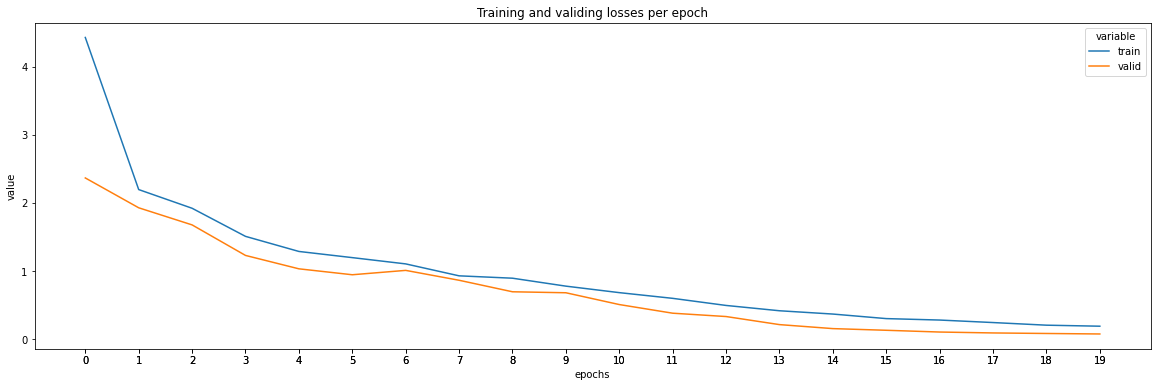

In [27]:
# list to keep track of train time
train_time = []

# train the model and save the best model
t_start = time.time()

train_model(tiff_classification_model,save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

## 6- Test the model

Load the save model and test it on the test dataset.

In [28]:
tiff_classification_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [29]:
test_model(tiff_classification_model)

Test Loss: 1.899119

Test Accuracy of Industrial: 53% ( 7/13)
Test Accuracy of AnnualCrop: 78% (11/14)
Test Accuracy of Highway: 33% ( 5/15)

Test Accuracy (Overall): 54% (23/42)


## 7- Visualize sample results

Visualize some results from the test set, showing first three channels of normalized images.

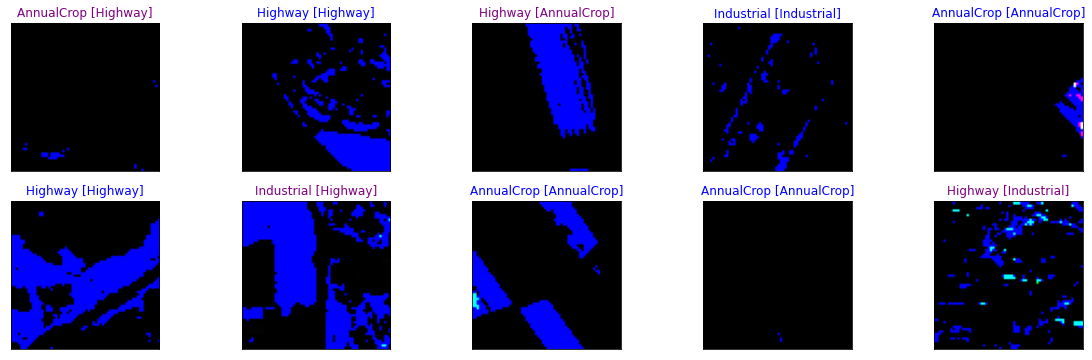

In [30]:
visualize_results(tiff_classification_model)

In [31]:
# delete the model to free memory
del tiff_classification_model

# 8 - Test with different values of hyperparameters

In [32]:
tiff_classification_model2 = CNN()
tiff_classification_model2 = tiff_classification_model2.to(device)

# Try different learning rate
learning_rate = 0.0001  

# Try different number of epochs
num_epochs = 50

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(tiff_classification_model2.parameters(), lr=learning_rate)

# Try different batch sizes
BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = False)

# path to save new model
save_path = 'tiff_simple_CNN2.pt'

Training for 50 epochs with 4 channels
Epoch: 1 	Training Loss: 2.753058 	Validation Loss: 1.385092
Epoch: 2 	Training Loss: 1.644953 	Validation Loss: 1.161495
Epoch: 3 	Training Loss: 1.396014 	Validation Loss: 1.130118
Epoch: 4 	Training Loss: 1.234847 	Validation Loss: 0.994342
Epoch: 5 	Training Loss: 1.099470 	Validation Loss: 0.892983
Epoch: 6 	Training Loss: 1.044358 	Validation Loss: 0.812998
Epoch: 7 	Training Loss: 0.947845 	Validation Loss: 0.762554
Epoch: 8 	Training Loss: 0.859063 	Validation Loss: 0.703082
Epoch: 9 	Training Loss: 0.856083 	Validation Loss: 0.659989
Epoch: 10 	Training Loss: 0.762538 	Validation Loss: 0.615937
Epoch: 11 	Training Loss: 0.724738 	Validation Loss: 0.565746
Epoch: 12 	Training Loss: 0.689268 	Validation Loss: 0.527856
Epoch: 13 	Training Loss: 0.652788 	Validation Loss: 0.488701
Epoch: 14 	Training Loss: 0.619937 	Validation Loss: 0.461699
Epoch: 15 	Training Loss: 0.603573 	Validation Loss: 0.436897
Epoch: 16 	Training Loss: 0.600327 	Vali

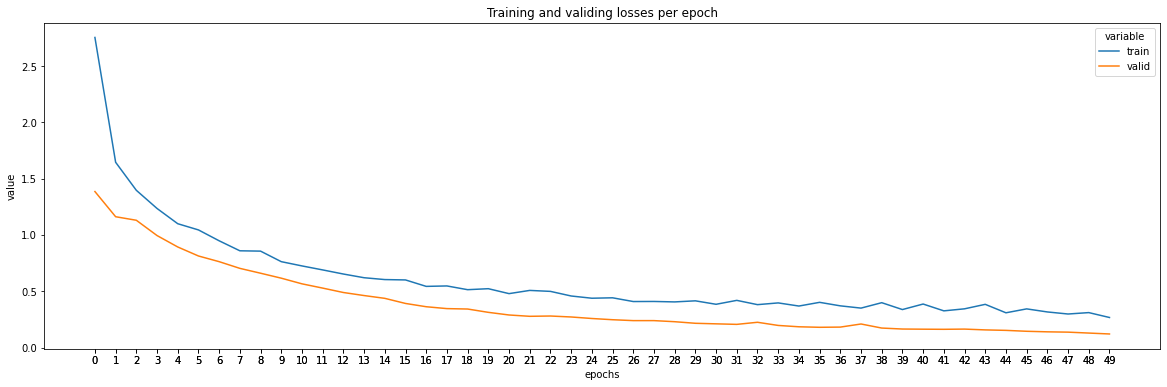

In [33]:
t_start = time.time()

train_model(tiff_classification_model2, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

In [34]:
tiff_classification_model2.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [35]:
test_model(tiff_classification_model2)

Test Loss: 1.589977

Test Accuracy of Industrial: 69% ( 9/13)
Test Accuracy of AnnualCrop: 42% ( 6/14)
Test Accuracy of Highway: 46% ( 7/15)

Test Accuracy (Overall): 52% (22/42)


In [36]:
del tiff_classification_model2

## 9- Augment images

We can augment the data by applyig random transformations like rotation and flip.

In [37]:
# image augmentation, random flip and rotation in addition to normalization

class RandomFlip(object):
    """Flip randomly the images in a sample."""

    def __call__(self, sample):
        image = sample
        
        if random.random() > 0.5:
            image =  image[:,::-1,:].copy()
        return image



class RandomRotation(object):
    """Rotate randomly the images in a sample."""

    def __call__(self, sample):
        image = sample
        
        n = random.randint(0, 3)
        if n:
            image = np.rot90(image, n, axes=(0,1)).copy()
        return image
    
transform = transforms.Compose([RandomFlip(), RandomRotation()])

We recreate the dataset with the newly defined transforms.

In [38]:
tiff_train_dataset = TIFFEODataset(tiff_train_data_list, tiff_train_class_list, transform=transform)
tiff_valid_dataset = TIFFEODataset(tiff_valid_data_list, tiff_valid_class_list, transform=None)
tiff_test_dataset = TIFFEODataset(tiff_test_data_list, tiff_test_class_list, transform=None)

#BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = True)

In [39]:
# Instantiate model
tiff_classification_model4 = CNN()
tiff_classification_model4 = tiff_classification_model4.to(device)

In [40]:
# set path to save trained model
save_path = 'tiff_simple_CNN4.pt'

Training for 30 epochs with 4 channels
Epoch: 1 	Training Loss: 2.230363 	Validation Loss: 1.589382
Epoch: 2 	Training Loss: 1.796691 	Validation Loss: 1.144415
Epoch: 3 	Training Loss: 1.573667 	Validation Loss: 1.114165
Epoch: 4 	Training Loss: 1.335277 	Validation Loss: 1.104304
Epoch: 5 	Training Loss: 1.306164 	Validation Loss: 1.122632
Epoch: 6 	Training Loss: 1.248231 	Validation Loss: 1.061067
Epoch: 7 	Training Loss: 1.282443 	Validation Loss: 1.003999
Epoch: 8 	Training Loss: 1.216656 	Validation Loss: 0.955568
Epoch: 9 	Training Loss: 1.141301 	Validation Loss: 0.924639
Epoch: 10 	Training Loss: 1.097828 	Validation Loss: 0.894385
Epoch: 11 	Training Loss: 1.125341 	Validation Loss: 0.868222
Epoch: 12 	Training Loss: 1.072347 	Validation Loss: 0.816176
Epoch: 13 	Training Loss: 1.061737 	Validation Loss: 0.797005
Epoch: 14 	Training Loss: 1.085381 	Validation Loss: 0.792330
Epoch: 15 	Training Loss: 1.035044 	Validation Loss: 0.786013
Epoch: 16 	Training Loss: 1.041019 	Vali

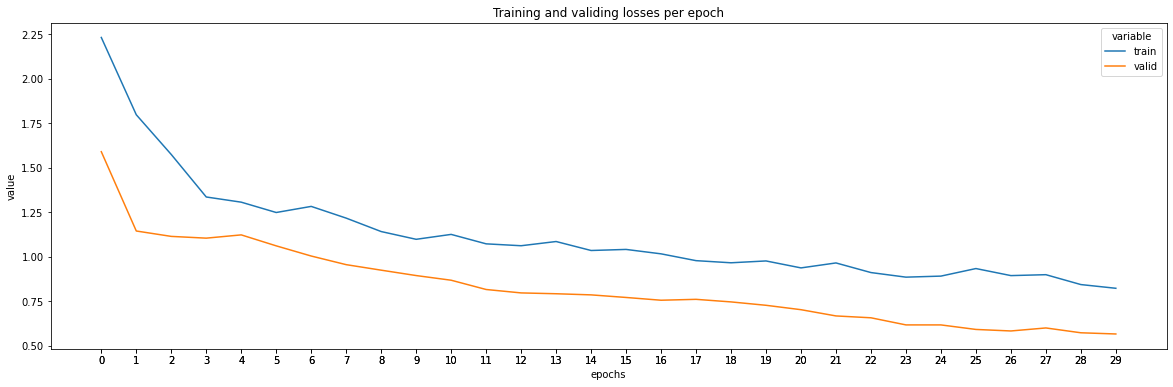

In [41]:
# set number of epochs and optimizer

num_epochs = 30

optimizer = torch.optim.AdamW(tiff_classification_model4.parameters(), lr=learning_rate)

# Train the model and get the training time
t_start = time.time()

train_model(tiff_classification_model4, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

In [42]:
tiff_classification_model4.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [43]:
test_model(tiff_classification_model4)

Test Loss: 1.094986

Test Accuracy of Industrial: 69% ( 9/13)
Test Accuracy of AnnualCrop: 50% ( 7/14)
Test Accuracy of Highway: 60% ( 9/15)

Test Accuracy (Overall): 59% (25/42)


In [44]:
del tiff_classification_model4

## 10 - Update the model number of layers, filter size

We create a new CNN with four convolutional layers, each with 3x3 kernels.

In [45]:
# deeper model with more conv layers
# 5 conv layers instead of 3
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # convolutional layer (sees 3x64x64 image tensor)
        self.conv1 = nn.Conv2d(nb_channels, 32, 3, padding=1)
        # convolutional layer (out 32x64x64 tensor)
        # poll below layer (out 32x32x32 tensor)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (out 32x32x32 tensor)
        # pool below layer (out 32x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (out 64x16x16 tensor)
        # pool below layer (out 64x8x8 tensor)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        # convolutional layer (out 64x8x8 tensor)
        # pool below layer (out 64x4x4 tensor)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # pass through each conv followed by pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten the output of the last conv-pool
        x = x.view(-1, 64 * 4 * 4)
        # dropout added to prevent overfitting
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [46]:
#instantiate model
tiff_classification_model5 = CNN2()

# put model on device
tiff_classification_model5 = tiff_classification_model5.to(device)

# Try different learning rate
learning_rate = 0.0001  

# Try different number of epochs
num_epochs = 20

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(tiff_classification_model5.parameters(), lr=learning_rate)

# Normalize with dataset values?
DATASET_NORM_IMG = False

# Define dataset with transforms
tiff_train_dataset = TIFFEODataset(tiff_train_data_list, tiff_train_class_list, transform=transform)
tiff_valid_dataset = TIFFEODataset(tiff_valid_data_list, tiff_valid_class_list, transform=None)
tiff_test_dataset = TIFFEODataset(tiff_test_data_list, tiff_test_class_list, transform=None)

# Try different batch sizes
BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = False)

# path to save new model
save_path = 'tiff_simple_CNN5.pt'

Training for 20 epochs with 4 channels
Epoch: 1 	Training Loss: 1.963990 	Validation Loss: 1.526449
Epoch: 2 	Training Loss: 1.729303 	Validation Loss: 1.423843
Epoch: 3 	Training Loss: 1.539160 	Validation Loss: 1.208899
Epoch: 4 	Training Loss: 1.315235 	Validation Loss: 1.150790
Epoch: 5 	Training Loss: 1.390858 	Validation Loss: 1.124829
Epoch: 6 	Training Loss: 1.342761 	Validation Loss: 1.168576
Epoch: 7 	Training Loss: 1.263124 	Validation Loss: 1.094854
Epoch: 8 	Training Loss: 1.279997 	Validation Loss: 1.031634
Epoch: 9 	Training Loss: 1.258212 	Validation Loss: 0.993731
Epoch: 10 	Training Loss: 1.199430 	Validation Loss: 1.001143
Epoch: 11 	Training Loss: 1.134884 	Validation Loss: 1.000942
Epoch: 12 	Training Loss: 1.138789 	Validation Loss: 1.000047
Epoch: 13 	Training Loss: 1.184928 	Validation Loss: 0.939291
Epoch: 14 	Training Loss: 1.141082 	Validation Loss: 0.866625
Epoch: 15 	Training Loss: 1.100152 	Validation Loss: 0.857908
Epoch: 16 	Training Loss: 1.035166 	Vali

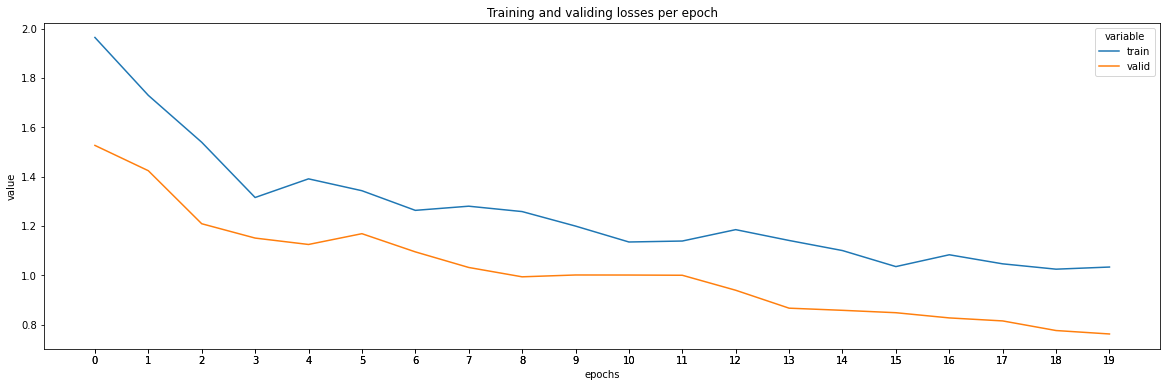

In [47]:
# Train the model and know the training time
t_start = time.time()

train_model(tiff_classification_model5, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

In [48]:
tiff_classification_model5.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [49]:
test_model(tiff_classification_model5)

Test Loss: 0.997448

Test Accuracy of Industrial: 84% (11/13)
Test Accuracy of AnnualCrop: 71% (10/14)
Test Accuracy of Highway: 53% ( 8/15)

Test Accuracy (Overall): 69% (29/42)


In [50]:
del tiff_classification_model5

## 11- Use a state of the art model from torchivision

We will use resnet18 and start by traning it only on our data without any pre-training.

In [51]:
# resnet18 no pretraining
resnet_model = torchvision.models.resnet18(weights=None)

In [52]:
#print(resnet_model)

We need to edit the first layer to pass it our number of input channels.

In [53]:
# edit the first layer of resnet18 to take our number of channels as input instead of 3
resnet_model.conv1 = nn.Conv2d(nb_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)   

We update the output size of the last layer to match our number of classes.

In [54]:
# Replace the last layer to output our number of classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, NB_CLS) 

In [55]:
resnet_model = resnet_model.to(device)

In [56]:
# Try different learning rate
learning_rate = 0.0001  

# Try different number of epochs
num_epochs = 20

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=learning_rate)

# path to save new model
save_path = 'tiff_resnet18_CNN.pt'

Training for 20 epochs with 4 channels
Epoch: 1 	Training Loss: 1.172509 	Validation Loss: 1.555648
Epoch: 2 	Training Loss: 1.022024 	Validation Loss: 1.396212
Epoch: 3 	Training Loss: 0.913751 	Validation Loss: 1.322022
Epoch: 4 	Training Loss: 0.800591 	Validation Loss: 1.085158
Epoch: 5 	Training Loss: 0.760198 	Validation Loss: 0.906413
Epoch: 6 	Training Loss: 0.716282 	Validation Loss: 0.672912
Epoch: 7 	Training Loss: 0.650579 	Validation Loss: 0.564748
Epoch: 8 	Training Loss: 0.605112 	Validation Loss: 0.535081
Epoch: 9 	Training Loss: 0.518091 	Validation Loss: 0.459488
Epoch: 10 	Training Loss: 0.525413 	Validation Loss: 0.463849
Epoch: 11 	Training Loss: 0.484616 	Validation Loss: 0.409703
Epoch: 12 	Training Loss: 0.468997 	Validation Loss: 0.332889
Epoch: 13 	Training Loss: 0.424716 	Validation Loss: 0.302248
Epoch: 14 	Training Loss: 0.397797 	Validation Loss: 0.265995
Epoch: 15 	Training Loss: 0.327845 	Validation Loss: 0.241315
Epoch: 16 	Training Loss: 0.302216 	Vali

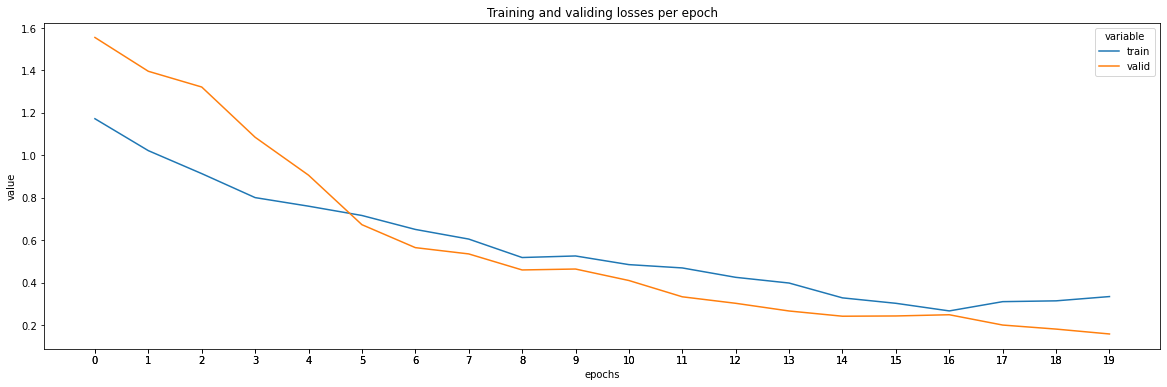

In [57]:
# Train the model and know the training time
t_start = time.time()

train_model(resnet_model, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

In [58]:
resnet_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [59]:
test_model(resnet_model)

Test Loss: 0.751292

Test Accuracy of Industrial: 76% (10/13)
Test Accuracy of AnnualCrop: 85% (12/14)
Test Accuracy of Highway: 73% (11/15)

Test Accuracy (Overall): 78% (33/42)


In [60]:
del resnet_model

### Transfer learning

We perform transfer learning with resnet18 pretrained on Imagenet. We first perform finetuning where we simply continue training the previously trained model, and then fixed fiture extraction where we freeze the parameters and only train the last linear layer.

In [79]:
tiff_train_dataset = TIFFEODataset(tiff_train_data_list, tiff_train_class_list)
tiff_valid_dataset = TIFFEODataset(tiff_valid_data_list, tiff_valid_class_list)
tiff_test_dataset = TIFFEODataset(tiff_test_data_list, tiff_test_class_list)

BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = False)

We will also need to update the input layer of the network to match the number of channels of our images, and replace the last layer with a linear layer matching our number of classes.

#### Finetuning

In [80]:
# resnet pre-trained on imagenet
resnet_model2 = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

# edit the first layer of resnet18 to take our number of channels as input instead of 3
resnet_model2.conv1 = nn.Conv2d(nb_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the last layer to output out number of classes
num_ftrs = resnet_model2.fc.in_features
resnet_model2.fc = nn.Linear(num_ftrs, NB_CLS)    

In [81]:
resnet_model_ft = resnet_model2.to(device)

In [82]:
# Try different learning rate
learning_rate = 0.0001  

# Try different numbere of epochs
num_epochs = 20

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(resnet_model_ft.parameters(), lr=learning_rate)

# path to save new model
save_path = 'tiff_resnet18_finetuned_CNN.pt'

Training for 20 epochs with 4 channels
Epoch: 1 	Training Loss: 1.308798 	Validation Loss: 1.102550
Epoch: 2 	Training Loss: 0.458445 	Validation Loss: 0.891278
Epoch: 3 	Training Loss: 0.250042 	Validation Loss: 0.618749
Epoch: 4 	Training Loss: 0.185881 	Validation Loss: 0.348953
Epoch: 5 	Training Loss: 0.134129 	Validation Loss: 0.184452
Epoch: 6 	Training Loss: 0.108402 	Validation Loss: 0.089982
Epoch: 7 	Training Loss: 0.099268 	Validation Loss: 0.042518
Epoch: 8 	Training Loss: 0.086081 	Validation Loss: 0.025101
Epoch: 9 	Training Loss: 0.077778 	Validation Loss: 0.020004
Epoch: 10 	Training Loss: 0.076675 	Validation Loss: 0.019165
Epoch: 11 	Training Loss: 0.069676 	Validation Loss: 0.014095
Epoch: 12 	Training Loss: 0.068649 	Validation Loss: 0.008489
Epoch: 13 	Training Loss: 0.071206 	Validation Loss: 0.008760
Epoch: 14 	Training Loss: 0.080927 	Validation Loss: 0.023988
Epoch: 15 	Training Loss: 0.068729 	Validation Loss: 0.009461
Epoch: 16 	Training Loss: 0.063017 	Vali

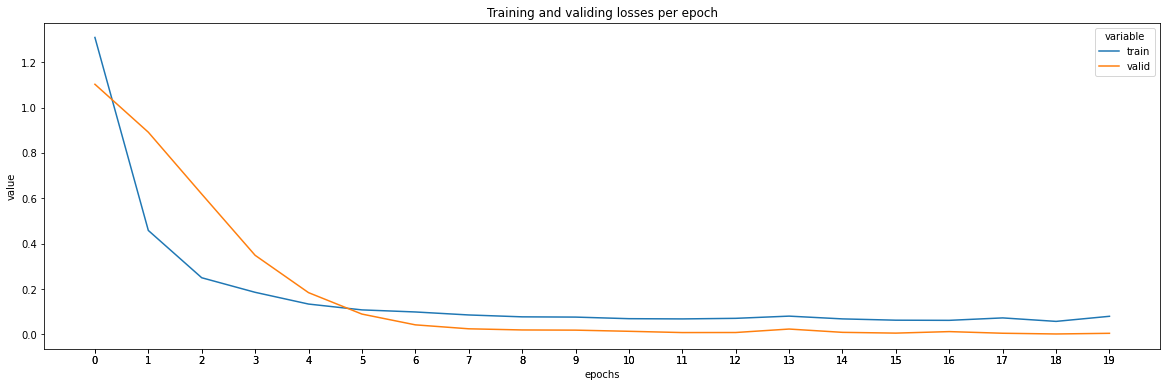

In [83]:
# Train the model and know the training time
t_start = time.time()

train_model(resnet_model_ft, save_path)

t_final = time.time()

train_time.append(t_final - t_start)

In [84]:
resnet_model_ft.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [85]:
test_model(resnet_model_ft)

Test Loss: 0.614095

Test Accuracy of Industrial: 69% ( 9/13)
Test Accuracy of AnnualCrop: 78% (11/14)
Test Accuracy of Highway: 80% (12/15)

Test Accuracy (Overall): 76% (32/42)


In [86]:
del resnet_model_ft

#### Fixed feature extractor

In [87]:
# resnet pre-trained on imagenet
resnet_model3 = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

# freeze parameters to avoid computing the gradient in the backward pass
for param in resnet_model3.parameters():
    param.requires_grad = False
    
# edit the first layer of resnet18 to take our number of channels as input instead of 3
resnet_model3.conv1 = nn.Conv2d(nb_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the last layer to output our number of classes
num_ftrs = resnet_model3.fc.in_features
resnet_model3.fc = nn.Linear(num_ftrs, NB_CLS)    

In [88]:
resnet_model_fe = resnet_model3.to(device)

In [89]:
# Try different learning rate
learning_rate = 0.0001  

# Try different number of epochs
num_epochs = 20

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(resnet_model_fe.fc.parameters(), lr=learning_rate)

# path to save new model
save_path = 'tiff_resnet18_featextract_CNN.pt'

Training for 20 epochs with 4 channels
Epoch: 1 	Training Loss: 1.176183 	Validation Loss: 1.355765
Epoch: 2 	Training Loss: 1.157527 	Validation Loss: 1.168828
Epoch: 3 	Training Loss: 1.138475 	Validation Loss: 1.189330
Epoch: 4 	Training Loss: 1.143480 	Validation Loss: 1.145427
Epoch: 5 	Training Loss: 1.100036 	Validation Loss: 1.099707
Epoch: 6 	Training Loss: 1.104538 	Validation Loss: 1.090382
Epoch: 7 	Training Loss: 1.063673 	Validation Loss: 1.065323
Epoch: 8 	Training Loss: 1.077238 	Validation Loss: 1.038356
Epoch: 9 	Training Loss: 1.105903 	Validation Loss: 1.039553
Epoch: 10 	Training Loss: 1.029230 	Validation Loss: 1.030688
Epoch: 11 	Training Loss: 1.024064 	Validation Loss: 1.023259
Epoch: 12 	Training Loss: 1.024909 	Validation Loss: 1.010396
Epoch: 13 	Training Loss: 1.026206 	Validation Loss: 0.999558
Epoch: 14 	Training Loss: 1.004536 	Validation Loss: 0.988316
Epoch: 15 	Training Loss: 0.988074 	Validation Loss: 0.977643
Epoch: 16 	Training Loss: 0.976240 	Vali

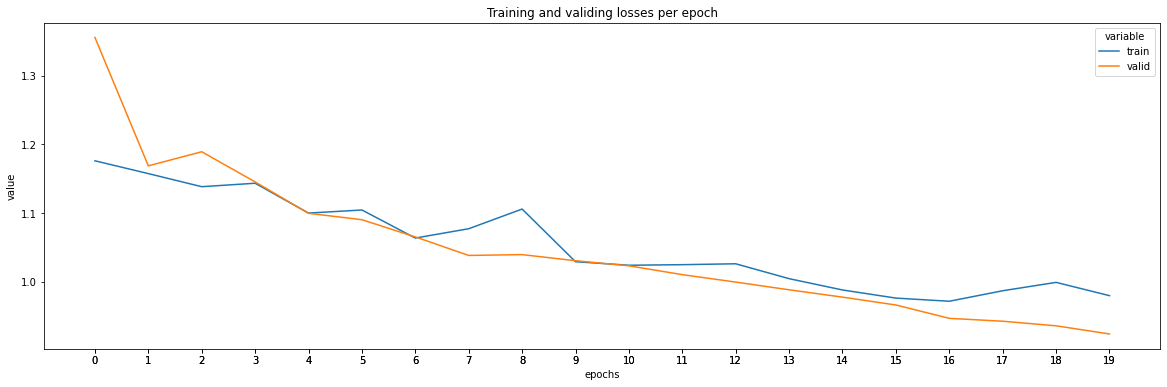

In [90]:
# Train the model and know the training time
t_start = time.time()

train_model(resnet_model_fe, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 

In [91]:
resnet_model_fe.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [92]:
test_model(resnet_model_fe)

Test Loss: 1.176435

Test Accuracy of Industrial: 38% ( 5/13)
Test Accuracy of AnnualCrop: 64% ( 9/14)
Test Accuracy of Highway: 33% ( 5/15)

Test Accuracy (Overall): 45% (19/42)


In [93]:
del resnet_model_fe

### Graphical recap of test accuracy and training times

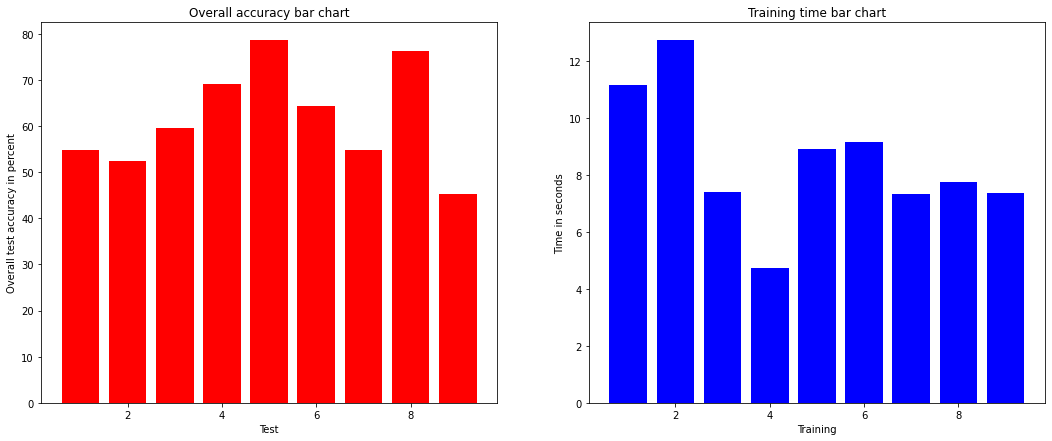

Average accuracy is 61.64 and average time is 8.51 with 3 classes used and proportion of 70.0% images used
Total time: 76.60 seconds ( 1 min )


In [94]:
x = np.arange(len(train_time)) + 1

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

ax1.bar(x, test_accuracy_overall, align='center', color="red")
ax1.set_title("Overall accuracy bar chart")
ax1.set_xlabel('Test')
ax1.set_ylabel('Overall test accuracy in percent')

ax2.bar(x, train_time, align='center', color="blue")
ax2.set_title("Training time bar chart")
ax2.set_xlabel('Training')
ax2.set_ylabel('Time in seconds')

plt.show()

print(f'Average accuracy is {sum(test_accuracy_overall)/len(test_accuracy_overall):0.2f} and average time is {sum(train_time)/len(train_time):0.2f} with {NB_CLS} classes used and proportion of {IMG_PROP*100:0.1f}% images used',)
print(f"Total time: {sum(train_time):0.2f} seconds ( {int(sum(train_time)//60)} min )")

### Your turn

#### Your own CNN
Create your own CNN that can outperform the simple CNN we created previously. Use different kernel sizes, a different number of convolutional layers, etc.

In [99]:
# TO DO
class CNN3(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # convolutional layer (sees 3x64x64 image tensor)
        self.conv1 = nn.Conv2d(nb_channels, 32, 3, padding=1)
        # convolutional layer (out 32x64x64 tensor)
        # poll below layer (out 32x32x32 tensor)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        # convolutional layer (out 32x32x32 tensor)
        # pool below layer (out 32x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (out 64x16x16 tensor)
        # pool below layer (out 64x8x8 tensor)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        # convolutional layer (out 64x8x8 tensor)
        # pool below layer (out 64x4x4 tensor)
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # pass through each conv followed by pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten the output of the last conv-pool
        x = x.view(-1, 64 * 4 * 4)
        # dropout added to prevent overfitting
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [101]:
#instantiate model
tiff_classification_model6 = CNN3()

# put model on device
tiff_classification_model6 = tiff_classification_model6.to(device)

# Try different learning rate
learning_rate = 0.0001  

# Try different number of epochs
num_epochs = 20

# Try different loss function
criterion = nn.CrossEntropyLoss()

# Try different optimizer 
optimizer = torch.optim.AdamW(tiff_classification_model6.parameters(), lr=learning_rate)

# Normalize with dataset values?
DATASET_NORM_IMG = False

# Define dataset with transforms
tiff_train_dataset = TIFFEODataset(tiff_train_data_list, tiff_train_class_list, transform=transform)
tiff_valid_dataset = TIFFEODataset(tiff_valid_data_list, tiff_valid_class_list, transform=None)
tiff_test_dataset = TIFFEODataset(tiff_test_data_list, tiff_test_class_list, transform=None)

# Try different batch sizes
BATCH_SIZE = 64
tiff_train_loader = DataLoader(tiff_train_dataset, batch_size = BATCH_SIZE, shuffle = True)
tiff_valid_loader = DataLoader(tiff_valid_dataset, batch_size = 10, shuffle = True)
tiff_test_loader = DataLoader(tiff_test_dataset, batch_size = 20, shuffle = False)

# path to save new model
save_path = 'tiff_simple_CNN5.pt'

# Train the model and know the training time
t_start = time.time()

train_model(tiff_classification_model6, save_path)

t_final = time.time()

train_time.append(t_final - t_start) 



TypeError: ignored

In [102]:
tiff_classification_model5.load_state_dict(torch.load(save_path))

RuntimeError: ignored

In [ ]:
test_model(tiff_classification_model5)

Test Loss: 0.997448

Test Accuracy of Industrial: 84% (11/13)
Test Accuracy of AnnualCrop: 71% (10/14)
Test Accuracy of Highway: 53% ( 8/15)

Test Accuracy (Overall): 69% (29/42)


In [ ]:
del tiff_classification_model5

#### Transfer learning

Look at model architectures available in torchvision for image classification [here](https://pytorch.org/vision/0.8/models.html). Choose one other than resnet18 and perform transfer learning with  the same data we have used in previous exercices. See if you can reach better results than what we had with resnet18.

In [96]:
# TO DO

### Resources
[Online course on CNNs](https://cs231n.github.io/convolutional-networks/#layers) <br>
[Pytorch documentation](https://pytorch.org/docs) <br>
[Pytorch tutorials](https://pytorch.org/tutorials)<br>
[Gdal documentation](https://gdal.org/)

### References
[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.


[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.